# RL and Advanced DL: Домашнее задание 3
Третье домашнее задание посвящено порождающим моделям, а точнее — порождающим состязательным сетям. Это самое маленькое и самое техническое задание в курсе, но что уж поделать. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:


In [1]:
# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

# !tar -xf facades.tar.gz

In [2]:
import os
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import tqdm
import random

In [8]:
class FacsdesDataset(Dataset):
    
    def __init__(self, folder='facades/train'):
        self.folder = folder
        self.files = [os.path.join(folder, f) for f in os.listdir(self.folder) if f.endswith('.jpg')]
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        
    def __getitem__(self, idx):
        imgs = Image.open(self.files[idx]).convert("RGB")
        img_template, img_original = imgs.crop((256, 0, 512, 256)), imgs.crop((0, 0, 256, 256))
        return self.transforms(img_template), self.transforms(img_original)    
        
    def __len__(self):
        return len(self.files)


train_dataset = FacsdesDataset(folder='facades/train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = FacsdesDataset(folder='facades/test')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

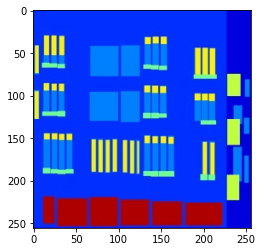

In [10]:
#check_dataset
plt.imshow(train_dataset[0][0].squeeze().permute(1,2,0) * 0.5 + 0.5);

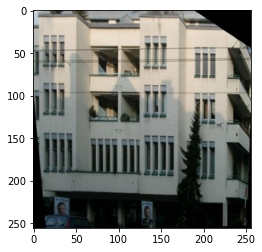

In [11]:
plt.imshow(train_dataset[0][1].squeeze().permute(1,2,0) * 0.5 + 0.5);

In [60]:
class ConvBlock(nn.Module):
    activation_funcs = {
        'Leaky': nn.LeakyReLU(0.1),
        'Relu': nn.ReLU()
    }
    
    def __init__(self, in_channels, out_channels, kernel=3, stride=1, padding=1, batchnorm=True, dropout=None, func='Leaky'):
        super().__init__()
        self.batchnorm = batchnorm
        self.dropout = dropout
        if dropout is not None:
            self.dropout = nn.Dropout2d(dropout)
        
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel, stride=stride, padding=padding)
        self.act_func = self.activation_funcs[func]
        
        self.batchnorm_module = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        y = self.act_func(self.conv(x))
        y = self.batchnorm_module(y) if self.batchnorm else y
        y = self.dropout(y) if self.dropout is not None else y
        
        return y

In [61]:
class ImgGenerator(nn.Module):
    def __init__(self, in_chanels, out_chanels, dropout_rate=0.2):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.tanh = nn.Tanh()
        self.encoder = nn.ModuleList([
            ConvBlock(in_chanels, 64),
            ConvBlock(64, 128, dropout=self.dropout_rate),
            ConvBlock(128, 256),
            ConvBlock(256, 512, dropout=self.dropout_rate),
            ConvBlock(512, 1024, batchnorm=False, kernel=2)
        ])
        
        self.decoder = nn.ModuleList([
            ConvBlock(1024 + 512, 512, func='Relu'),
            ConvBlock(512 + 256, 256, func='Relu'),
            ConvBlock(256 + 128, 128, func='Relu'),
            ConvBlock(128 + 64, 64, func='Relu'),
            ConvBlock(64, out_chanels, func='Relu', kernel=1),
        ])
        
    def forward(self, x):
        
        enc_list = list()
#         enc = self.encoder[0](enc)
#         enc_list.append(enc)
        enc = x
        for i in range(len(self.encoder)):
            enc = self.encoder[i](enc)
            enc_list.append(enc)
            
#         enc = torch.cat([enc, enc[-2]], axis=1)
#         dec = self.decoder[0](enc)
        dec = enc_list[-1]
        for i in range(len(self.decoder) - 1):
            enc_idx = len(self.decoder) - i - 1
            dec = torch.cat([dec, enc_list[enc_idx - 1]], axis=1)
            dec = self.decoder[i](enc)
            
        dec = self.decoder[-1](dec)
        
        return self.tanh(dec)

In [62]:
class Discriminator(nn.Module):

    def __init__(self, in_channels=6):
        super().__init__()
        
        self.model = nn.Sequential(
            ConvBlock(in_channels, 64, batchnorm=False),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
            nn.Conv2d(512, 1, kernel_size=4)
        )

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x = self.model(x)
        return x

In [63]:
def display_progress(cond, fake, real, figsize=(10,5)):
    with torch.no_grad():
        cond = cond.cpu().permute(1, 2, 0) * 0.5 + 0.5
        fake = fake.cpu().permute(1, 2, 0) * 0.5 + 0.5
        real = real.cpu().permute(1, 2, 0) * 0.5 + 0.5
    
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(cond)
    ax[1].imshow(real)
    ax[2].imshow(fake)
    plt.show()

Модель Pix2Pix - обучает генератор и дискриминатор

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [64]:
class Pix2Pix:

    def __init__(self, device, in_channels=3, out_channels=3, g_lr=2e-4, d_lr=2e-4):

        self.G = ImgGenerator(in_channels, out_channels)
        self.D = Discriminator(in_channels + out_channels)
        
        self.device = device
        self.G.to(self.device)
        self.D.to(self.device)

        self.discriminator_criterion = nn.BCEWithLogitsLoss()
        self.generator_criterion = nn.L1Loss()
        
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=lr)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=lr)

                    
    def train_epoch(self, dataloader):
        loss_g_l, loss_d_l = list(), list()
        for batch in dataloader:
            template, original= batch
            template = template.to(self.device)
            original = original.to(self.device)
            
            self.G.eval()
            self.D.train()
            
            fake = self.netG(template)
            
            # update Discriminator
            self.d_optimizer.zero_grad() 
            
            fake_logits = self.D(fake.detach(), template)
            orig_logits = self.D(original, cond)
            fake_loss = self.discriminator_criterion(fake_logits, torch.zeros_like(fake_logits))
            real_loss = self.discriminator_criterion(real_logits, torch.ones_like(real_logits))
            loss_d = (real_loss + fake_loss) / 2
            
            lossD.backward()
            self.d_optimizer.step()
            
            loss_d_l.append(loss_d.detach().cpu().item())
            
            # update G
            self.g_optimizer.zero_grad()
            self.g_optimizer.train()
            self.d_optimizer.eval()
            
            with torch.no_grad():
                logits = self.D(fake, template)
            
            loss_d = self.discriminator_criterion(logits, torch.ones_like(logits))
            loss_g = self.generator_criterion(fake, real)
            loss_g = loss_d + 100 * loss_g
    
            loss_g.backward()
            self.optimizerG.step()  
            
            loss_g_l.append(loss_g)
            
            
        
        mean_loss_g = np.mean(loss_g_l)
        mean_loss_d = np.mean(loss_d_l)
        return mean_loss_g, mean_loss_d
            

In [65]:
model = Pix2Pix(device)

device= cpu


In [ ]:
def train(model, train_dataloader, val_dataloader):
    

In [66]:
%%time
for i_epoch in tqdm.tqdm(range(1, 200)):
    lossG, lossD = model.train_epoch(train_dataloader)
    print(i_epoch, lossG, lossD)

    with torch.no_grad():
        real, cond = train_dataset[random.randrange(len(train_dataset))]
        fake = model.netG(cond.unsqueeze(0).to(model.device))
        display_progress(cond, fake[0], real)   

  0%|                                                                                                                                                                                                            | 0/199 [00:26<?, ?it/s]


KeyboardInterrupt: 